[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/paper/paper.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

Running locally


## Summary

In this work, we present <b>fastMONAI</b>, a low-code Python-based open source deep learning library built on top of fastai [@howard2020fastai; @howard2020deep], MONAI [@monai], and TorchIO [@perez2021torchio]. We created the library to simplify the use of state-of-the-art deep learning techniques in 3D medical image analysis for solving classification, regression, and segmentation tasks. fastMONAI provides the users with functionalities to step through data loading, preprocessing, training, and result interpretations.

The paper is structured in the following way: it first states the need for the research, then it showcases various applications and the user-friendlyness, followed by dicussion about documentation, usability and maintainability.

Note that the PDF version of our paper is automatically generated from Jupyter Notebook available in the fastMONAI GitHub repo: [https://github.com/MMIV-ML/fastMONAI](https://github.com/MMIV-ML/fastMONAI). Using the notebook, you can step through all the content, reproducing the below computations. 
"Let us change our traditional attitude to the construction of programs: Instead of imagining that our main task is to instruct a computer what to do, let us concentrate rather on explaining to human beings what we want a computer to do."[@donaldknuth]

## Statement of need 

The pace of developments in deep learning is incredibly fast, with new models, techniques, and tricks constantly appearing. As a result, it is easy to get stuck on something less-than-optimal when using deep learning to solve a particular set of problems while also being in danger of getting lost in minor technical details when constructing models for concrete tasks. The fastai deep learning library [@howard2020fastai; @howard2020deep] provides both a high-level API that automatically incorporates many established best practices and a low-level API in which one can modify details related to model architectures, training strategies, data augmentation, and more. 

fastai is a general deep learning library built on top of PyTorch. Healthcare imaging has a variety of domain-specific demands, including medical imaging formats, data storage and transfer, data labeling procedures, domain-specific data augmentation, and evaluation methods. MONAI Core [@monai] and TorchIO [@perez2021torchio] target deep learning in healthcare imaging, incorporating multiple best practices. MONAI Core, the primary library of Project MONAI, is built on top of PyTorch and provides domain-specific functionalites for medical imaging, including network architectures, metrics, and loss functions. 
TorchIO is a Python-based open-source library for efficent loading, preprocessing, and augmentation of 3D medical images. 

A visual representation learning system is determined by three key factors: network architecture chosen, training methods, and data [@woo2023convnext]. Our combination of fastai, MONAI Core, and TorchIO into fastMONAI with custom modules like MedDataset makes it possible to easily construct, use and train powerful models for a range of medical imaging tasks, using all the best practices and domain-specific features incorporated into these three libraries. The library is developed at The Mohn Medical Imaging and Visualization Centre (MMIV), which is part of the Department of Radiology at Haukeland University Hospital . One of the center's key objectives is to develop new quantitative methods for high field MRI, CT and hybrid PET/CT/MR in both preclincal and clincal settings, with the aim of improving decision-making and patient care. fastMONAI can ease the entry of new practitioners into medical AI and make it possible to quickly construct good baseline models (that can be further optimized by going deeper into the underlying libraries <-- kan dette faa det til aa virke som en tynn wrapper?). 

## The software: PyTorch, fastai, MONAI, and torchIO

![Overview of the components in fastMONAI and their connections to underlying libraries](paper_files/diagram.png)
<br>
**Figure 1:** </b> Overview of the components in fastMONAI and their connections to underlying libraries. 

## Applications

In this section, we will explore how to use our library. In fastMONAI's online documentation (https://fastmonai.no/), multiple tutorials cover different classification, regression, and segmentation tasks. 

### Classification

The following line imports all of the functions and classes from the fastMONAI library: 

In [ ]:
from fastMONAI.vision_all import *

***Download external data***

For this task, we will download the MedMNIST lung nodule data with corresponding labels, indicating whetere the nodules are benign (b) or malignant (m).
We will download the data with the following line of code:  

In [ ]:
df, _ = download_NoduleMNIST3D(max_workers=8)

***Inspect the data***

Let's look at how the processed DataFrame is formatted:

In [ ]:
df.head(1)

,img_path,labels,is_val
0,../data/NoduleMNIST3D/train_images/0_nodule.nii.gz,b,False


Before feeding the data into a model, we must create a `DataLoaders` object for our dataset. There are several ways to get the data in `DataLoaders`. 
In the following line, we call the ` ImageDataLoaders.from_df` factory method, which is the most basic way of building a `DataLoaders`. 

Here, we pass the processed DataFrame, define the columns for the images `fn_col` and the labels `label_col`, voxel spacing `resample`, some transforms `item_tfms`, and the batch size `bs`. 

In [ ]:
#TODO flytte ut
def get_item_tfms(size, degrees=5): 
    return [ZNormalization(), PadOrCrop(size=size), 
            RandomAffine(degrees=degrees, isotropic=True)]

In [ ]:
dls = MedImageDataLoaders.from_df(df, fn_col='img_path', 
                                  label_col='labels', 
                                  item_tfms=get_item_tfms(size=28, degrees=35), 
                                  resample=1,
                                  bs=64)

We can now take a look at a batch of images in the training set using `show_batch` :

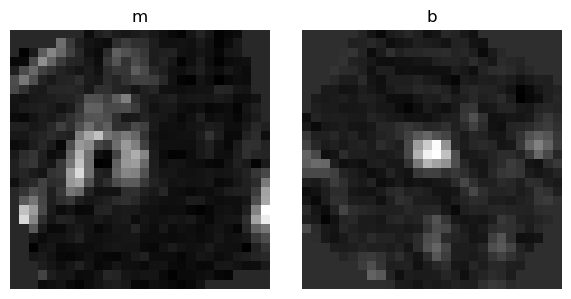

In [ ]:
dls.show_batch(max_n=2, anatomical_plane=2)

Class imbalance is a common challenge in medical datasets:

In [ ]:
df.labels.value_counts()

b    986
m    337
Name: labels, dtype: int64


Balanced weight is a simple technique for addressing imbalanced classification models. It adjusts the loss function of the model so that misclassifying the minority class is more heavily penalized than misclassifying the majority class. 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_train = df.loc[~df.is_val].labels
weights = torch.Tensor(compute_class_weight(class_weight='balanced', 
                                            classes=np.unique(y_train),
                                            y=y_train.values.reshape(-1)))
weights

tensor([0.6709, 1.9627])

***Create and train a 3D model***

Next, we import a classification network from MONAI and define the input image size, number of classes to predict, channels, etc.  

In [ ]:
from monai.networks.nets import Classifier

model = Classifier(in_shape=[1, 28, 28, 28], classes=2, 
                   channels=(8, 16, 32),strides=(2, 2, 2, 2))

In [ ]:
loss_func = CrossEntropyLossFlat(weight=weights)

Then we can create a `Learner`, which is a fastai object that combines the data and our defined model for training.

In [ ]:
learn = Learner(dls, model,loss_func=loss_func, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(4) 

epoch,train_loss,valid_loss,accuracy,time
0,0.591324,0.530592,0.776515,00:04
1,0.540495,0.490810,0.776515,00:02
2,0.483361,0.493118,0.803030,00:02
3,0.445119,0.495560,0.787879,00:02


With the model trained, let's look at some predictions on the validation data.

> **Note:** Small random variations are involved in training CNN models. Hence, when running the notebook, you will probably not see exactly the same results shown here.

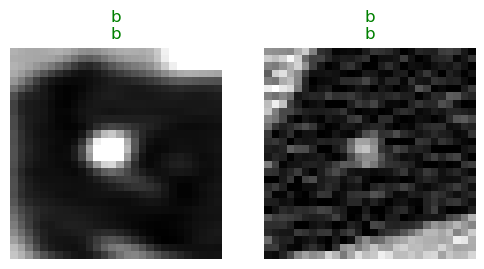

In [ ]:
learn.show_results(max_n=2, anatomical_plane=2) 

Showing samples with target value and their corresponding predictions (target|predicition). 

***Interpretation***

Let's look at where our trained model becomes confused while making predictions on the validation data:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

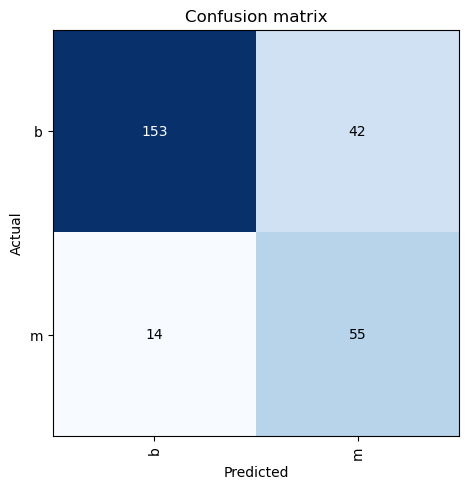

In [ ]:
interp.plot_confusion_matrix()

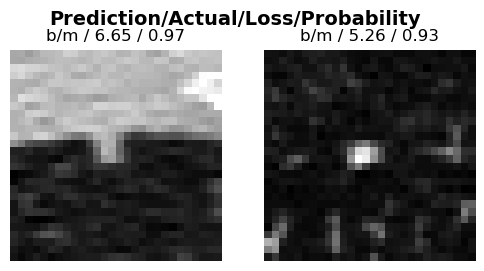

In [ ]:
interp.plot_top_losses(k=2, anatomical_plane=2)

***Test-time augmentation***

Test-time augmentation (TTA) is a technique where you apply transforms used during traing when making predictions to produce average output.  

In [ ]:
preds, targs = learn.tta(n=4); 
accuracy(preds, targs)

TensorBase(0.8106)

### Semantic segmentation

Let's take a closer look at the library using another vision application task, semantic segmentation on IXI Tiny dataset (a small version of the IXI dataset). In semantic segmentation, a class label is assigned to each pixel or voxel in an image, in this case, distinguishing brain tissue from non-brain tissue. 

In [ ]:
path = Path('../data')
STUDY_DIR = download_ixi_tiny(path=path)

Root directory for IXITiny found: ../data/IXITiny
2023-01-27 08:50:01,847 - INFO - Expected md5 is None, skip md5 check for file ../data/IXITiny/IXI.xls.
2023-01-27 08:50:01,848 - INFO - File exists: ../data/IXITiny/IXI.xls, skipped downloading.
Preprocessing ../data/IXITiny/IXI.xls


In [ ]:
df = pd.read_csv(STUDY_DIR/'dataset.csv')

***Inspect the data ...***

`MedDataset` is a class to extract and present information about your dataset.

In [ ]:
med_dataset = MedDataset(path=STUDY_DIR/'image', reorder=True, max_workers=6)

In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,44,55,83,4.13,3.95,2.18,RAS+,../data/IXITiny/image/IXI002-Guys-0828_image.nii.gz,566


In [ ]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([4.13, 3.95, 2.18], True)

Get the largest image size in the dataset with resampling (note that some network architecure requires the tensor to be divisible by 16)

In [ ]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[44.0, 55.0, 83.0]

In [ ]:
size = [48, 48, 96]

***Data augmentation***

In fastMONAI, various data augmentation techniques are available for traning vision models, and they can also be optionaly applied during infrence using TTA (as we have seen earlier). 

Data augmentation is an important regualization technique in training vision models, which aims to expand the diversity of a given dataset by performing random, realistic transformations such as rotation, zoom, ant others). The following code cell shows the utilization of a few of these transformations. Full list of available augmentations  in the library can be found at https://fastmonai.no/vision_augment.

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(size), 
             RandomAffine(scales=0.1, degrees=5, p=0.5), RandomFlip(p=0.5)] 

***Load the data (TODO)***

As we mentioned earlier, there are several ways to get the data in `DataLoaders`. In this section, let's rebuild using `DataBlock`. 
Here we need to define what our input and target should be (`MedImage` and `MedMaskBlock` for segmentation), how to get the images and the labels, how to split the data, item transforms that should be applied during training, reorder voxel orientations, and voxel spacing. Take a look at fastai's documentation for DataBlock for further information: [https://docs.fast.ai/data.block.html#DataBlock](https://docs.fast.ai/data.block.html#DataBlock).

**NB:** It is important to select the method of splitting carefully. One potential issue to consider is patient overlap, which can occur when the same patient's data is present in both the training and validation/testing sets (TODO:cite?). In the IXI dataset (used in this section), we do not need to consider the possibility of patient overlap as there is only one image per patient.

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(valid_pct=0.2, seed=42),
                      get_x=ColReader('t1_path'),
                      get_y=ColReader('labels'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

Now we pass our processed DataFrame and the batch size (bs) to create a `DataLoaders` object. 
Batch size (bs) refers to the number of training examples processed through the network before updating the weights. The higher the batch size, the more memory space is needed. You can read more about batch size selection in the Deep Learning Tuning Playbook: https://github.com/google-research/tuning_playbook 

In [ ]:
dls = dblock.dataloaders(df, bs=8)

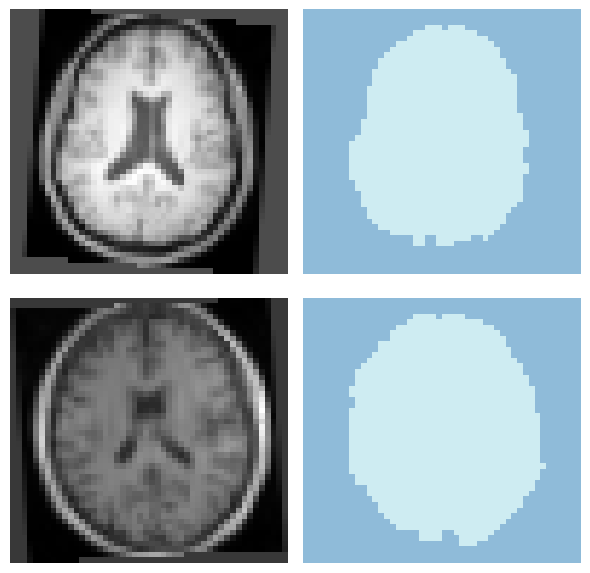

In [ ]:
dls.show_batch(max_n=2, anatomical_plane=2)

In [ ]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(438, 109)

***Network architectures and loss functions***

You can import various models and loss functions directly from MONAI Core as shown below: 

In [ ]:
from monai.networks.nets import UNet, AttentionUnet
from monai.losses import DiceLoss, DiceFocalLoss

In [ ]:
# model = UNet(spatial_dims=3, in_channels=1, out_channels=1,
#              channels=(16, 32, 64, 128),strides=(2, 2, 2), num_res_units=2)

model = AttentionUnet(spatial_dims=3, in_channels=1, out_channels=1,
                      channels=(16, 32, 64, 128),strides=(2, 2, 2))

In [ ]:
loss_func = CustomLoss(loss_func=DiceFocalLoss(sigmoid=True))

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=[binary_dice_score, binary_hausdorff_distance])
# learn.summary()

***Learning rate finder***

We used the default learning rate before, but we might want to find an optimal value. For this, we can use the learning rate finder. 
Rule of thumb to pick a learning rate: 
- Minimum/10 
- The steepest point(where the loss is clearly decreasing)

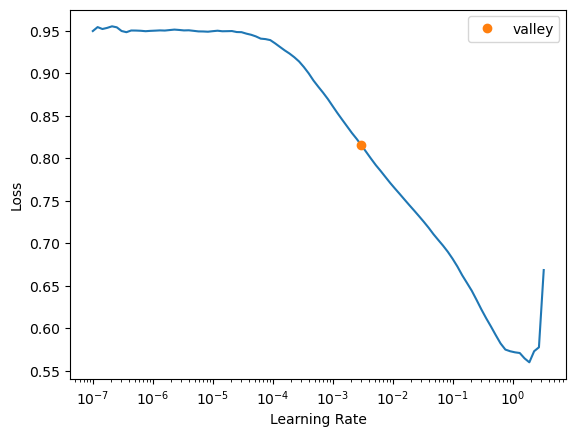

In [ ]:
lr = learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, lr.valley)

epoch,train_loss,valid_loss,binary_dice_score,binary_hausdorff_distance,time
0,0.565980,0.466951,0.940546,6.440546,00:15
1,0.477293,0.438608,0.950276,5.074091,00:15


In [ ]:
learn.save('model-1')

Path('models/model-1.pth')

***Export and share models***

Export model and share both the trained weights and the learner on Hugginface (https://huggingface.co/docs/hub/repositories-getting-started) and use git tag for marked version release (TODO:kun gjort repo.add_tag()). Version control for shared models is important for tracking changes and be able to to roll back to previous versions if there are any issues with the latest model in production. 

In [ ]:
learn.export('models/export.pkl')
store_variables(pkl_fn='models/vars.pkl', size=size, 
                reorder=reorder, resample=resample)

## Documentation, usability, and maintainability

We have written the entire fastMONAI library using nbdev, a tool for exploratory programming that allows you to write, test, and document a Python library in Jupyter Notebooks. fastMONAI contains several practical tools to ensure the software's user-friendliness. 

fastMONAI comes with a documentation page ([https://fastmonai.no](https://fastmonai.no)) and step-by-step tutorials on how to use the software for various medical imaging tasks (e.g., classification, regression, and segmentation). Tests are written directly in notebooks, and continuous integration with GitHub Actions runs the tests on each push, making software development easier with multiple collaborators. 

To ease further extensions of our library through contributions, we have added a short guide on how to contribute to the project. As mentioned, this paper is written as a notebook and automatically converted to a markdown file. The latest version is always available on GitHub. 

## Research projects using fastMONAI

The fastMONAI library has been used for various medical imaging tasks, including, predicting brain age using T1-weighted scans in [@kaliyugarasan2020brain], skull-stripping in [@kaliyugarasan20202d], pulmonary nodule classification from CT images in [@kaliyugarasan2021pulmonary], and tumor segmentation in cervical cancer from multi-parametric pelvic MRI in [@hodneland2022fully]. Recently, it was also used for vertebra segmentation in a multi-center study [@kaliyugarasan2023spine]. 

## Acknowledgments

The Trond Mohn Research Foundation supported our work through the project “Computational medical imaging and machine learning - methods, infrastructure and applications” at the Mohn Medical Imaging and Visualization Centre, grant number BFS2018TMT07, and a grant from the Western Norway Regional Health Authority (Helse Vest RHF), project F-12532.

## References